In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import distinctipy
from scipy.interpolate import UnivariateSpline, interp1d
import glob,os
import matplotlib.colors as colors
import quaternion as quat
import matplotlib
import matplotlib.patheffects as pe

import numpy as np
%matplotlib inline

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

figaspectratio = 1.25

peri=2458013

In [4]:
def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
        
    if isinstance(a,(np.floating,float,int)): a=a*np.ones_like(beta)
    else: a=a[None,:]

    if isinstance(b,(np.floating,float,int)): b=b*np.ones_like(beta)
    else: b=b[None,:]

    if isinstance(c,(np.floating,float,int)): c=c*np.ones_like(beta)
    else: c=c[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.einsum('ijk->jki',np.array([1/a**2,1/b**2,1/c**2]))
    Ts=np.sqrt(np.einsum('ijk,ijk,ijk->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,ijk->ij',obs,obs,C))

    cosa=np.einsum('ijk,ijk,ijk->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

def magvalues(time,args,theta,phi,psi,betai,deltaV):
    p,a,b,c,alpha=args
    beta=2*np.pi*((time)%p)/p
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta))
    return(curve[0,:])

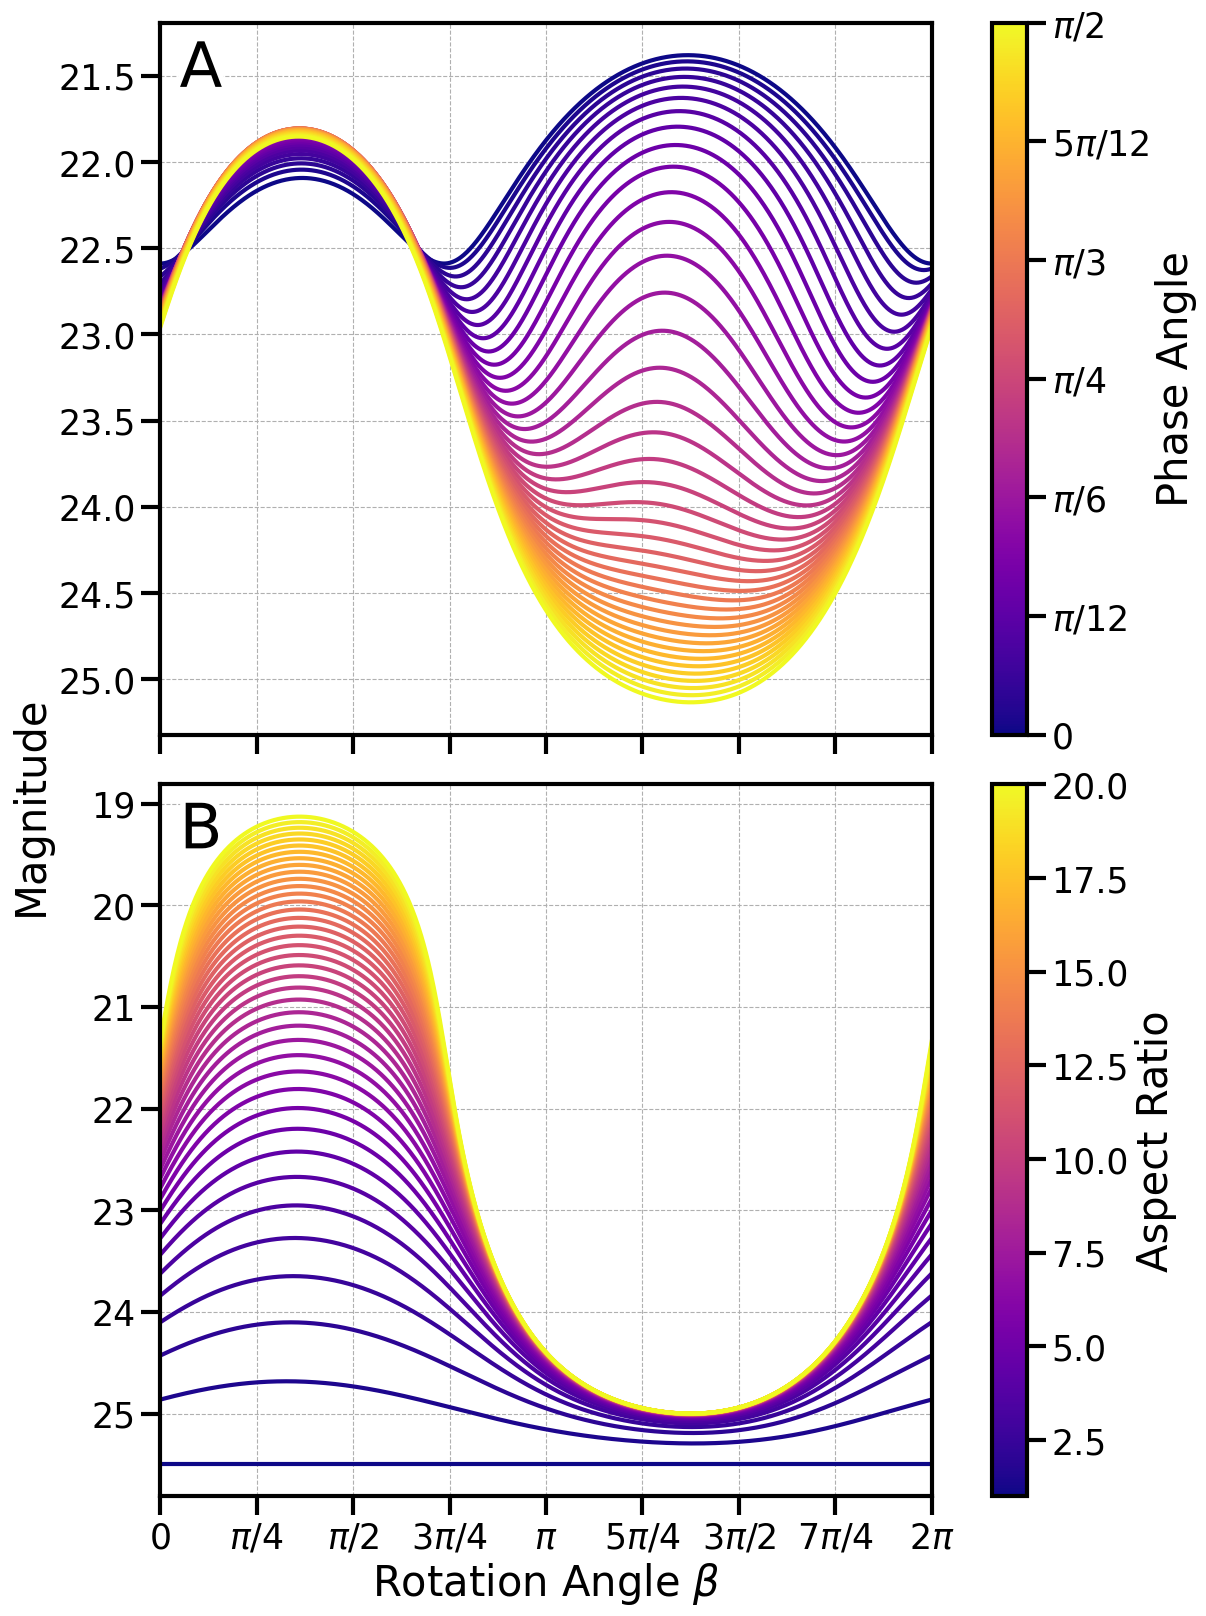

In [10]:
import matplotlib as mpl

optparams=[4.75924567, 1.42272942, 1.24770105, 4.35406442, 32.18076141]

N=40

fig,axes=plt.subplots(2,1,figsize=(12,16),sharex=True,constrained_layout=True)

cmap=matplotlib.cm.get_cmap('plasma')
cols=cmap(np.linspace(0,1,N))
phsls=np.linspace(0,np.pi/2,N)
asprat=np.linspace(1,20,N)

unit=np.linspace(0,2*np.pi,1000)
for i in range(N):
    axes[0].plot(unit,magvalues(unit,(2*np.pi,115,115,19,phsls[i]*np.ones(1000)),*optparams),c=cols[i],lw=3)
    axes[1].plot(unit,magvalues(unit,(2*np.pi,asprat[i]*20,asprat[i]*20,20,np.pi/2*np.ones(1000)),*optparams),c=cols[i],lw=3)

norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=axes[0],ticks=np.linspace(0,np.pi/2,7))
cb.ax.set_yticklabels([0,r"$\pi/12$",r"$\pi/6$",r"$\pi/4$",r"$\pi/3$",r"$5\pi/12$",r"$\pi/2$"])
cb.set_label("Phase Angle",fontsize=30)

norm = mpl.colors.Normalize(vmin=1, vmax=20)
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=axes[1])
cb.set_label("Aspect Ratio",fontsize=30)

axes[0].grid(ls='dashed',zorder=1)
axes[0].set_xlim([0,2*np.pi])
axes[0].set_xticks(np.linspace(0,2*np.pi,9),[0,r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$",
                   r"$5\pi/4$",r"$3\pi/2$",r"$7\pi/4$",r"$2\pi$"])
axes[0].set_ylim(axes[0].get_ylim()[::-1])

axes[1].grid(ls='dashed',zorder=1)
axes[1].set_xlim([0,2*np.pi])
axes[1].set_xticks(np.linspace(0,2*np.pi,9),[0,r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$",
                   r"$5\pi/4$",r"$3\pi/2$",r"$7\pi/4$",r"$2\pi$"])
axes[1].set_ylim(axes[1].get_ylim()[::-1])

axes[1].set_xlabel(r"Rotation Angle $\beta$",fontsize=30)

axes[0].text(0.025,.91,"A",fontsize=45,transform=axes[0].transAxes,
             path_effects=[pe.Stroke(linewidth=8, foreground='w'), pe.Normal()])
axes[1].text(0.025,.91,"B",fontsize=45,transform=axes[1].transAxes,
            path_effects=[pe.Stroke(linewidth=8, foreground='w'), pe.Normal()])

fig.supylabel("Magnitude",fontsize=30)

fig.savefig('../Figures and Paper/ML15_dependence_effects.pdf',
           bbox_inches='tight',dpi=100)